In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib as mpl
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.cross_validation import PredefinedSplit
import sys
sys.path.append('.')
import utils

/home/guoshuai/.local/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
def get_ks_score(prob, label):
    '''
    计算ks得分
    :param pro: 属于坏人的概率
    :param label: 真实标签
    :return: ks得分
    '''
    df = pd.DataFrame(data = {'label': label, 'prob': prob})
    df['prob'] = df['prob'].map(lambda x: round(x, 3))
    total = pd.DataFrame({'total': df.groupby('prob')['label'].count()})
    bad = pd.DataFrame({'bad': df.groupby('prob')['label'].sum()})
    all_data = total.merge(bad, how = 'left', left_index = True, right_index = True)
    all_data['good'] = all_data['total'] - all_data['bad']
    all_data.reset_index(inplace = True)
    all_data['goodCumPer'] = all_data['good'].cumsum() / all_data['good'].sum()
    all_data['badCumPer'] = all_data['bad'].cumsum() / all_data['bad'].sum()
    KS_m = all_data.apply(lambda x: x.goodCumPer - x.badCumPer, axis = 1)
    return max(KS_m)

def my_scoring(self, X, y, sample_weight=None):
    scoring_prob = self.predict_proba(X)[:, 1]
    false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(y, scoring_prob)
    auc = metrics.auc(false_positive_rate, true_positive_rate)
    ks = get_ks_score(scoring_prob, y)
    #print(X.shape)
    #score_need = 2*auc*ks/(auc + ks)
    score_need = (auc + ks)
    return ks

In [3]:
data = pd.read_csv('./cmh_level/data_feature_selected.csv')
data = utils.data_init(data)
data.shape

(79054, 124)

In [4]:
y_prob_need = []
params = {
    'booster': 'gbtree',
    'objective': 'binary:logitraw',
    'eval_metric': 'auc',
    
    'eta': 0.1,# learning rate 0.2 --
    
    'scale_pos_weight': 34, #2 --
    
    'max_depth': 2,# --
    'min_child_weight': 1.5, #1.6 
    'gamma': 0.5, #越大算法越保守 ??
    'subsample': 0.5, #每棵树随机采样比例 --
    'colsample_bytree': 0.9, #每棵树随机采样的列数的占比 2 --
    
    'max_delta_step': 1, # 每棵树权重改变的最大步长 可用于类别不平衡 logisticregresion --

    'alpha': 0.9, #l1正则化参数 --
    'lambda': 0.6, #l2正则化参数 --

    'silent': 0,
}
train_auc, train_ks = [], []
val_auc, val_ks = [], []
test_auc, test_ks = [], []

data_y = data.pop('label').as_matrix()
data_X = data.as_matrix()
i = 0

for j in range(1):
    for X_train, X_val, X_test, y_train, y_val, y_test in utils.kfold(data_X, data_y, num_fold = 10):
        print(i)
        i = i + 1
        min_max_scaler = MinMaxScaler()
        min_max_scaler.fit(X_train)
        X_train = min_max_scaler.transform(X_train)
        X_val = min_max_scaler.transform(X_val)
        X_test = min_max_scaler.transform(X_test)
        
        dtrain = xgb.DMatrix(X_train, label=y_train) # xgboost data style
        dval = xgb.DMatrix(X_val, label=y_val)
        dtest = xgb.DMatrix(X_test, label=y_test)
        
        xg_model = xgb.train(params, dtrain, num_boost_round=84) #10-150
        
        y_train_pred_prob = xg_model.predict(dtrain)
        y_val_pred_prob = xg_model.predict(dval)
        y_test_pred_prob = xg_model.predict(dtest)
        temp_auc, temp_ks = utils.model_key_performance(y_train_pred_prob, y_train)
        train_auc.append(temp_auc)
        train_ks.append(temp_ks)
        temp_auc, temp_ks = utils.model_key_performance(y_val_pred_prob, y_val)
        val_auc.append(temp_auc)
        val_ks.append(temp_ks)
        temp_auc, temp_ks = utils.model_key_performance(y_test_pred_prob, y_test)
        test_auc.append(temp_auc)
        test_ks.append(temp_ks)
        y_prob_need.append(y_test_pred_prob)

print(np.mean(train_auc), np.mean(train_ks))
print(np.mean(val_auc), np.mean(val_ks))
print(np.mean(test_auc), np.mean(test_ks))

0
1
2
3
4
5
6
7
8
9
0.849367247481 0.544701450375
0.810656404607 0.514224644403
0.805495407042 0.493302019735


In [5]:
y_test_prob_need = y_test_pred_prob - np.amin(y_test_pred_prob) + 0.01
y_test_prob_need = y_test_prob_need/(np.max(y_test_prob_need)+1)
y_test_prob_need = np.log(60)*np.log(y_test_prob_need/(1-y_test_prob_need)) + 600
pr_need_max = np.max(y_test_prob_need)
pr_need_min = np.min(y_test_prob_need)
y_test_prob_need = (y_test_prob_need - pr_need_min + 0.01) / (pr_need_max - pr_need_min + 0.01)

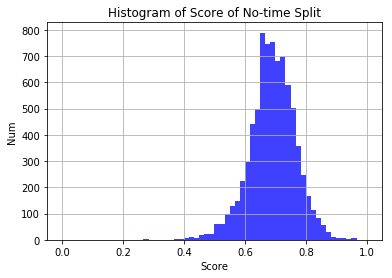

In [6]:
n, bins, patches = plt.hist(y_test_prob_need, 60, facecolor='b', alpha=0.75)

plt.xlabel('Score')
plt.ylabel('Num')
plt.title('Histogram of Score of No-time Split')
plt.grid(True)
plt.show()

In [7]:
prob = y_test_prob_need
label = y_test
df = pd.DataFrame(data = {'label': label, 'prob': prob})
df['prob'] = df['prob'].map(lambda x: round(x, 3))
total = pd.DataFrame({'total': df.groupby('prob')['label'].count()})
bad = pd.DataFrame({'bad': df.groupby('prob')['label'].sum()})
all_data = total.merge(bad, how = 'left', left_index = True, right_index = True)
all_data['good'] = all_data['total'] - all_data['bad']
all_data.reset_index(inplace = True)
all_data['goodCumPer'] = all_data['good'].cumsum() / all_data['good'].sum()
all_data['badCumPer'] = all_data['bad'].cumsum() / all_data['bad'].sum()
all_data['ks'] = all_data.apply(lambda x: x.goodCumPer - x.badCumPer, axis = 1)
threshold = all_data[all_data.ks == all_data['ks'].max()].prob.values[0]
print(threshold)

0.729


In [12]:
y_test_label_need = []
for x in y_test_prob_need:
    if x < 0.772:
        y_test_label_need.append(0)
    else:
        y_test_label_need.append(1)

confusion_matrix(y_test, y_test_label_need)

array([[6907,  932],
       [  33,   33]])

In [9]:
importance = xg_model.get_fscore()

In [10]:
type(importance)

dict